# **Cancel Culture - Classification Modeling Notebook**

---

**Post-Cleaning Modeling Notebook**

---

# -- > 🛑 **FIX**: Add cmts re: post-cleaning, modeling

---

>

---

# **Imports**

---

> I will import several packages and modules to perform my modeling steps. I use different parts of Scikit-Learn's numerous packages for the majority of my modeling. In addition to SKLearn, I tested models from XGBoost as well as Imblearn towards the end of the modeling process.
>
> I include the usual packages as well: pandas, numpy, matplotlib, and seaborn. Additionally, I have several personal functions that I use during the modeling process.

---

In [1]:
## Jupyter Notebook setting to reload functions when called
%load_ext autoreload
%autoreload 2

In [2]:
## Data Handling
import pandas as pd
import numpy as np

## Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

## Personal functions
from bmc_functions import classification as clf

## SKLearn and Modeling Tools
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import ExtraTreesClassifier, AdaBoostClassifier,\
                             GradientBoostingClassifier 
from sklearn import set_config
set_config(display='diagram')

# from xgboost import XGBClassifier

# from imblearn.over_sampling import SMOTENC
from imblearn.ensemble import BalancedBaggingClassifier,\
                                BalancedRandomForestClassifier,\
                                EasyEnsembleClassifier, RUSBoostClassifier

In [3]:
## Settings
%matplotlib inline
plt.style.use('seaborn-talk')
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')
pd.set_option('max_rows', 50)

# **Reading the DataFrames**

---

> In my prior EDA notebook, I reviewed, cleaned, and performed some pre-processing steps to prepare my data separately before modeling. I saved the data as a .pickle file to preserve the datatypes; now I will re-read the data for modeling purposes.

---

# -- > 🛑 **FIX**: update data in EDA notebook - keep type, outliers.

In [4]:
data = pd.read_pickle('./data/data_prepped.pickle',
                           compression = 'gzip')
data.head(5)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,arrival_date,arrival_day
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.00,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,999,0,Transient,0.00,0,0,Check-Out,2015-07-01,2015-07-01,Wednesday
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.00,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,999,0,Transient,0.00,0,0,Check-Out,2015-07-01,2015-07-01,Wednesday
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.00,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,999,0,Transient,75.00,0,0,Check-Out,2015-07-02,2015-07-01,Wednesday
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.00,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304,0,Transient,75.00,0,0,Check-Out,2015-07-02,2015-07-01,Wednesday
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.00,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240,0,Transient,98.00,0,1,Check-Out,2015-07-03,2015-07-01,Wednesday


# **Train/Test Split**

# -- > 🛑 **FIX**: Make sure to encode cats as "category"

In [5]:
## Identifying target
target= 'is_canceled'

In [6]:
## Dropping target and "reservation_status" (nearly identical indicator)

X = data.drop(columns = [target, 'reservation_status']).copy()
y = data[target].copy()

In [7]:
## Checking for missing values
print(f'Missing values for X:\n {X.isna().sum()[X.isna().sum() >0]}\n')
print(f'Missing values for y: {y.isna().sum()}')

Missing values for X:
 Series([], dtype: int64)

Missing values for y: 0


In [8]:
## Splitting - stratify to maintain class balance b/t X_train/_test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, 
                                                    random_state=42, 
                                                    stratify=y)

In [9]:
## Saving memory by deleting unused X, y
del X, y

In [10]:
## Specifying numeric columns for preprocessing
num_cols = X_train.select_dtypes('number').columns.to_list()
num_cols

['lead_time',
 'stays_in_weekend_nights',
 'stays_in_week_nights',
 'adults',
 'children',
 'babies',
 'is_repeated_guest',
 'previous_cancellations',
 'previous_bookings_not_canceled',
 'booking_changes',
 'days_in_waiting_list',
 'adr',
 'required_car_parking_spaces',
 'total_of_special_requests']

In [11]:
## Specifying numeric columns for preprocessing
cat_cols = X_train.select_dtypes(include='object').columns.to_list()
cat_cols

['hotel',
 'arrival_date_year',
 'arrival_date_month',
 'arrival_date_week_number',
 'arrival_date_day_of_month',
 'meal',
 'country',
 'market_segment',
 'distribution_channel',
 'reserved_room_type',
 'assigned_room_type',
 'deposit_type',
 'agent',
 'customer_type',
 'arrival_day']

# **Prepping the Pipeline**

---

> Pipeline to streamline modeling steps:
* Preprocessing: OHE, scaling, outliers via ƒ-XF?
* Modeling: RFC, BRFC
* GSCV: include as part of pipeline
* Get results:
    * Feature importances - **SHAP**

---

In [12]:
## Creating ColumnTransformer and sub-transformers for imputation and encoding

### --- Creating column pipelines --- ###

cat_pipe = Pipeline(steps=[('ohe', OneHotEncoder(handle_unknown='ignore',
                                                 sparse=False))])

num_pipe = Pipeline(steps=[('scaler', StandardScaler())])

## Instantiating the ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[('num', num_pipe, num_cols),
                  ('cat', cat_pipe, cat_cols)
                  ])

preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['lead_time', 'stays_in_weekend_nights',
                                  'stays_in_week_nights', 'adults', 'children',
                                  'babies', 'is_repeated_guest',
                                  'previous_cancellations',
                                  'previous_bookings_not_canceled',
                                  'booking_changes', 'days_in_waiting_list',
                                  'adr', 'required_car_parking_spaces',
                                  'total_of_special_r...s']),
                                ('cat',
                                 Pipeline(steps=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['hotel', 'arrival_date_year',
                                  'arrival_date_month',
                                  'arrival_date_week_number',
                                  'arrival_date_day_of_month', 'meal',
                                  'country', 'market_segment',
                                  'distribution_channel', 'reserved_room_type',
                                  'assigned_room_type', 'deposit_type', 'agent',
                                  'customer_type', 'arrival_day'])])

In [13]:
## Fitting feature preprocessor
preprocessor.fit(X_train)

## Getting feature names from OHE
ohe_cat_names = preprocessor.named_transformers_['cat'].named_steps['ohe'].get_feature_names(cat_cols)

## Generating list for column index
final_cols = [*num_cols, *ohe_cat_names]

final_cols

['lead_time',
 'stays_in_weekend_nights',
 'stays_in_week_nights',
 'adults',
 'children',
 'babies',
 'is_repeated_guest',
 'previous_cancellations',
 'previous_bookings_not_canceled',
 'booking_changes',
 'days_in_waiting_list',
 'adr',
 'required_car_parking_spaces',
 'total_of_special_requests',
 'hotel_City Hotel',
 'hotel_Resort Hotel',
 'arrival_date_year_2015',
 'arrival_date_year_2016',
 'arrival_date_year_2017',
 'arrival_date_month_April',
 'arrival_date_month_August',
 'arrival_date_month_December',
 'arrival_date_month_February',
 'arrival_date_month_January',
 'arrival_date_month_July',
 'arrival_date_month_June',
 'arrival_date_month_March',
 'arrival_date_month_May',
 'arrival_date_month_November',
 'arrival_date_month_October',
 'arrival_date_month_September',
 'arrival_date_week_number_1',
 'arrival_date_week_number_10',
 'arrival_date_week_number_11',
 'arrival_date_week_number_12',
 'arrival_date_week_number_13',
 'arrival_date_week_number_14',
 'arrival_date_week_n

In [14]:
## Transform the data via the ColumnTransformer preprocessor

X_train_tf = preprocessor.transform(X_train)
X_train_tf_df = pd.DataFrame(X_train_tf, columns=final_cols, index=X_train.index)

X_test_tf = preprocessor.transform(X_test)
X_test_tf_df = pd.DataFrame(X_test_tf, columns=final_cols, index=X_test.index)

display(X_train_tf_df.head(5),X_test_tf_df.head(5))

,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,hotel_City Hotel,hotel_Resort Hotel,arrival_date_year_2015,arrival_date_year_2016,arrival_date_year_2017,arrival_date_month_April,arrival_date_month_August,arrival_date_month_December,arrival_date_month_February,arrival_date_month_January,arrival_date_month_July,arrival_date_month_June,arrival_date_month_March,arrival_date_month_May,arrival_date_month_November,arrival_date_month_October,arrival_date_month_September,arrival_date_week_number_1,arrival_date_week_number_10,arrival_date_week_number_11,arrival_date_week_number_12,arrival_date_week_number_13,arrival_date_week_number_14,arrival_date_week_number_15,arrival_date_week_number_16,arrival_date_week_number_17,arrival_date_week_number_18,arrival_date_week_number_19,arrival_date_week_number_2,arrival_date_week_number_20,arrival_date_week_number_21,arrival_date_week_number_22,arrival_date_week_number_23,arrival_date_week_number_24,arrival_date_week_number_25,arrival_date_week_number_26,arrival_date_week_number_27,arrival_date_week_number_28,arrival_date_week_number_29,arrival_date_week_number_3,arrival_date_week_number_30,arrival_date_week_number_31,arrival_date_week_number_32,arrival_date_week_number_33,arrival_date_week_number_34,arrival_date_week_number_35,arrival_date_week_number_36,arrival_date_week_number_37,arrival_date_week_number_38,arrival_date_week_number_39,arrival_date_week_number_4,arrival_date_week_number_40,arrival_date_week_number_41,arrival_date_week_number_42,arrival_date_week_number_43,arrival_date_week_number_44,arrival_date_week_number_45,arrival_date_week_number_46,arrival_date_week_number_47,arrival_date_week_number_48,arrival_date_week_number_49,arrival_date_week_number_5,arrival_date_week_number_50,arrival_date_week_number_51,arrival_date_week_number_52,arrival_date_week_number_53,arrival_date_week_number_6,arrival_date_week_number_7,arrival_date_week_number_8,arrival_date_week_number_9,arrival_date_day_of_month_1,arrival_date_day_of_month_10,arrival_date_day_of_month_11,arrival_date_day_of_month_12,arrival_date_day_of_month_13,arrival_date_day_of_month_14,arrival_date_day_of_month_15,arrival_date_day_of_month_16,arrival_date_day_of_month_17,arrival_date_day_of_month_18,arrival_date_day_of_month_19,arrival_date_day_of_month_2,arrival_date_day_of_month_20,arrival_date_day_of_month_21,arrival_date_day_of_month_22,arrival_date_day_of_month_23,arrival_date_day_of_month_24,arrival_date_day_of_month_25,arrival_date_day_of_month_26,arrival_date_day_of_month_27,arrival_date_day_of_month_28,arrival_date_day_of_month_29,arrival_date_day_of_month_3,arrival_date_day_of_month_30,arrival_date_day_of_month_31,arrival_date_day_of_month_4,arrival_date_day_of_month_5,arrival_date_day_of_month_6,arrival_date_day_of_month_7,arrival_date_day_of_month_8,arrival_date_day_of_month_9,meal_BB,meal_FB,meal_HB,meal_SC,meal_Undefined,country_ABW,country_AGO,country_AIA,country_ALB,country_AND,country_ARE,country_ARG,country_ARM,country_ASM,country_ATA,country_ATF,country_AUS,country_AUT,country_AZE,country_BEL,country_BEN,country_BFA,country_BGD,country_BGR,country_BHR,country_BIH,country_BLR,country_BOL,country_BRA,country_BRB,country_CAF,country_CHE,country_CHL,country_CHN,country_CIV,country_CMR,country_CN,country_COL,country_COM,country_CPV,country_CRI,country_CUB,country_CYM,country_CYP,country_CZE,country_DEU,country_DJI,country_DMA,country_DNK,country_DOM,country_DZA,country_ECU,country_EGY,country_ESP,country_EST,country_ETH,country_FIN,country_FJI,country_FRA,country_FRO,country_GAB,country_GBR,country_GEO,country_GGY,country_GHA,country_GIB,country_GLP,country_GNB,country_GRC,country_GTM,country_HKG,country_HND,country_HRV,country_HUN,country_IDN,country_IMN,country_IND,country_IRL,country_IRN,country_IRQ,country_ISL,country_ISR,

,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,hotel_City Hotel,hotel_Resort Hotel,arrival_date_year_2015,arrival_date_year_2016,arrival_date_year_2017,arrival_date_month_April,arrival_date_month_August,arrival_date_month_December,arrival_date_month_February,arrival_date_month_January,arrival_date_month_July,arrival_date_month_June,arrival_date_month_March,arrival_date_month_May,arrival_date_month_November,arrival_date_month_October,arrival_date_month_September,arrival_date_week_number_1,arrival_date_week_number_10,arrival_date_week_number_11,arrival_date_week_number_12,arrival_date_week_number_13,arrival_date_week_number_14,arrival_date_week_number_15,arrival_date_week_number_16,arrival_date_week_number_17,arrival_date_week_number_18,arrival_date_week_number_19,arrival_date_week_number_2,arrival_date_week_number_20,arrival_date_week_number_21,arrival_date_week_number_22,arrival_date_week_number_23,arrival_date_week_number_24,arrival_date_week_number_25,arrival_date_week_number_26,arrival_date_week_number_27,arrival_date_week_number_28,arrival_date_week_number_29,arrival_date_week_number_3,arrival_date_week_number_30,arrival_date_week_number_31,arrival_date_week_number_32,arrival_date_week_number_33,arrival_date_week_number_34,arrival_date_week_number_35,arrival_date_week_number_36,arrival_date_week_number_37,arrival_date_week_number_38,arrival_date_week_number_39,arrival_date_week_number_4,arrival_date_week_number_40,arrival_date_week_number_41,arrival_date_week_number_42,arrival_date_week_number_43,arrival_date_week_number_44,arrival_date_week_number_45,arrival_date_week_number_46,arrival_date_week_number_47,arrival_date_week_number_48,arrival_date_week_number_49,arrival_date_week_number_5,arrival_date_week_number_50,arrival_date_week_number_51,arrival_date_week_number_52,arrival_date_week_number_53,arrival_date_week_number_6,arrival_date_week_number_7,arrival_date_week_number_8,arrival_date_week_number_9,arrival_date_day_of_month_1,arrival_date_day_of_month_10,arrival_date_day_of_month_11,arrival_date_day_of_month_12,arrival_date_day_of_month_13,arrival_date_day_of_month_14,arrival_date_day_of_month_15,arrival_date_day_of_month_16,arrival_date_day_of_month_17,arrival_date_day_of_month_18,arrival_date_day_of_month_19,arrival_date_day_of_month_2,arrival_date_day_of_month_20,arrival_date_day_of_month_21,arrival_date_day_of_month_22,arrival_date_day_of_month_23,arrival_date_day_of_month_24,arrival_date_day_of_month_25,arrival_date_day_of_month_26,arrival_date_day_of_month_27,arrival_date_day_of_month_28,arrival_date_day_of_month_29,arrival_date_day_of_month_3,arrival_date_day_of_month_30,arrival_date_day_of_month_31,arrival_date_day_of_month_4,arrival_date_day_of_month_5,arrival_date_day_of_month_6,arrival_date_day_of_month_7,arrival_date_day_of_month_8,arrival_date_day_of_month_9,meal_BB,meal_FB,meal_HB,meal_SC,meal_Undefined,country_ABW,country_AGO,country_AIA,country_ALB,country_AND,country_ARE,country_ARG,country_ARM,country_ASM,country_ATA,country_ATF,country_AUS,country_AUT,country_AZE,country_BEL,country_BEN,country_BFA,country_BGD,country_BGR,country_BHR,country_BIH,country_BLR,country_BOL,country_BRA,country_BRB,country_CAF,country_CHE,country_CHL,country_CHN,country_CIV,country_CMR,country_CN,country_COL,country_COM,country_CPV,country_CRI,country_CUB,country_CYM,country_CYP,country_CZE,country_DEU,country_DJI,country_DMA,country_DNK,country_DOM,country_DZA,country_ECU,country_EGY,country_ESP,country_EST,country_ETH,country_FIN,country_FJI,country_FRA,country_FRO,country_GAB,country_GBR,country_GEO,country_GGY,country_GHA,country_GIB,country_GLP,country_GNB,country_GRC,country_GTM,country_HKG,country_HND,country_HRV,country_HUN,country_IDN,country_IMN,country_IND,country_IRL,country_IRN,country_IRQ,country_ISL,country_ISR,

# **--->** 🛑 Add Comment: Class Imbalance

---

> Due to class imbalance, will attempt to use "class_weight = balanced" to correct.

---

# **Baseline Model**


|-------------------------------- Classification Metrics -----------------------------------|

Training balanced accuracy score: 0.5
Testing balanced accuracy score: 0.51
	- The training score is smaller by 0.01 points.

Training data log loss: 16.06
Testing data log loss: 15.89



|---------------------------- Classification Report - Testing Data -------------------------|

              precision    recall  f1-score   support

           0       0.63      0.64      0.64     18792
           1       0.38      0.38      0.38     11056

    accuracy                           0.54     29848
   macro avg       0.51      0.51      0.51     29848
weighted avg       0.54      0.54      0.54     29848



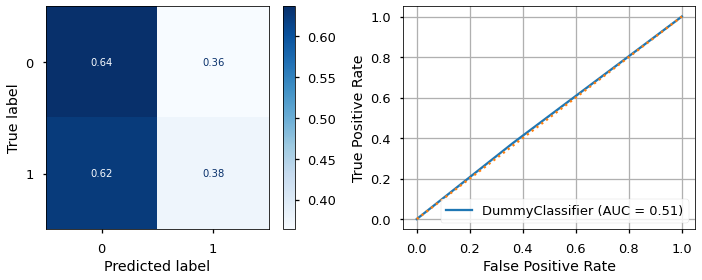


|---------------------------- Classification Report - Training Data ------------------------|

              precision    recall  f1-score   support

           0       0.63      0.63      0.63     56374
           1       0.37      0.37      0.37     33168

    accuracy                           0.53     89542
   macro avg       0.50      0.50      0.50     89542
weighted avg       0.53      0.53      0.53     89542



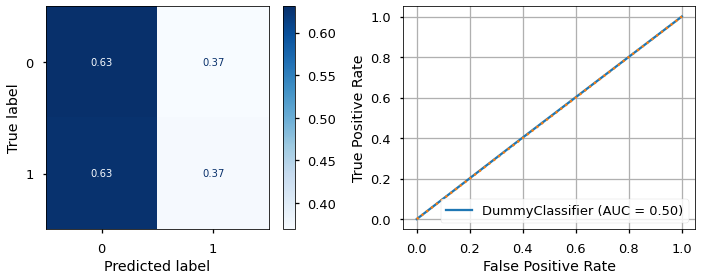

In [15]:
## Creating baseline classifier model

base = DummyClassifier(strategy='stratified', random_state = 42)

base.fit(X_train_tf_df, y_train)

clf.evaluate_classification(base,X_train = X_train_tf_df, y_train = y_train,
                           X_test = X_test_tf_df, y_test = y_test, 
                           metric = 'balanced accuracy')

# -- > 🛑 **FIX**: Re-run all models w/ new data, kfold CV

# **Logistic Regression Model**

---

**Results:**

> Training balanced accuracy score: 0.82
> 
> Testing balanced accuracy score: 0.82
> 
> * *The scores are the same size.*
>
> Training data log loss: 0.37
>
> Testing data log loss: 0.37

---

**Interpretation**

> 

---

In [16]:
## Speeding up SKLearn via Intel(R) Extension for Scikit-learn*
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [17]:
## LogReg Model

from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(max_iter = 600,C = .1,solver = 'lbfgs',
                            n_jobs=-1,random_state = 42)

logreg.fit(X_train_tf_df, y_train)

LogisticRegression(C=0.1, max_iter=600, n_jobs=1, random_state=42)


|-------------------------------- Classification Metrics -----------------------------------|

Training balanced recall score: 0.81
Testing balanced recall score: 0.81
	- The scores are the same size.

Training data log loss: 0.35
Testing data log loss: 0.38



|---------------------------- Classification Report - Testing Data -------------------------|

              precision    recall  f1-score   support

           0       0.84      0.91      0.87     18792
           1       0.82      0.71      0.76     11056

    accuracy                           0.83     29848
   macro avg       0.83      0.81      0.81     29848
weighted avg       0.83      0.83      0.83     29848



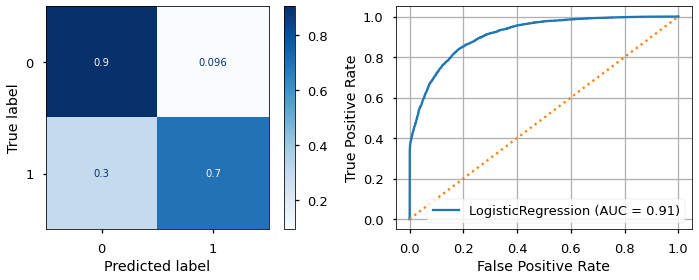


|---------------------------- Classification Report - Training Data ------------------------|

              precision    recall  f1-score   support

           0       0.84      0.91      0.87     56374
           1       0.82      0.71      0.76     33168

    accuracy                           0.83     89542
   macro avg       0.83      0.81      0.82     89542
weighted avg       0.83      0.83      0.83     89542



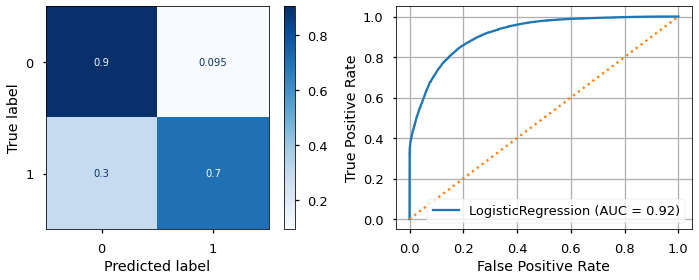

In [18]:
clf.evaluate_classification(logreg, X_train = X_train_tf_df, y_train = y_train,
                           X_test = X_test_tf_df, y_test = y_test,
                          metric = 'balanced recall')

# LogisticRegressionCV

---

>

---

In [19]:
# ## LogRegCV Model

# from sklearn.linear_model import LogisticRegressionCV

# logregcv = LogisticRegressionCV(cv = 3, max_iter = 750,random_state = 42)

# logregcv.fit(X_train_tf_df, y_train)

In [20]:
# clf.evaluate_classification(logregcv, X_train = X_train_tf_df, y_train = y_train,
#                            X_test = X_test_tf_df, y_test = y_test,
#                           metric = 'balanced recall')

In [21]:
# logregcv.C_

In [22]:
# logregcv.coef_.shape

In [23]:
# lrcoef_series = pd.Series(logregcv.coef_.flatten(), index=X_train_tf_df.columns)
# lrcoef_series

In [24]:
# lrcoef_series.sort_values()

In [25]:
# data['deposit_type'].value_counts()

In [26]:
# sns.countplot(data = data, hue='deposit_type', x=target)

In [27]:
# data.loc[:,['is_canceled', 'reservation_status']]

In [28]:
# data.nunique()

---

> Above cells show exploration of results and trying to understand why particular agents are such strong coefficients

---

# **SMOTENC**

final_cols = [*num_cols, *ohe_cat_names]

In [29]:
# smote_feats = [False]*len(num_cols) +[True]*len(ohe_cat_names)
# smote_feats

In [30]:
# smote_nc = SMOTENC(categorical_features=smote_feats, random_state=42)
# X_resampled, y_resampled = smote_nc.fit_resample(X_train_tf_df, y_train)

# **Random Forest Model**

---

**Results:**

> Training balanced recall score: 0.99
> 
> Testing balanced recall score: 0.88
>
> * *The training score is larger by 0.11 points.*
>
> Training data log loss: 0.08
>
> Testing data log loss: 0.27

---

**Interpretation**

> 

---

In [31]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(class_weight = 'balanced', n_jobs=-1,
                             random_state=42)

rfc.fit(X_train_tf_df, y_train)

RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=42)


|-------------------------------- Classification Metrics -----------------------------------|

Training balanced recall score: 0.96
Testing balanced recall score: 0.88
	- The training score is larger by 0.08 points.

Training data log loss: 0.50
Testing data log loss: 0.51



|---------------------------- Classification Report - Testing Data -------------------------|

              precision    recall  f1-score   support

           0       0.93      0.88      0.91     18792
           1       0.82      0.89      0.85     11056

    accuracy                           0.88     29848
   macro avg       0.87      0.88      0.88     29848
weighted avg       0.89      0.88      0.89     29848



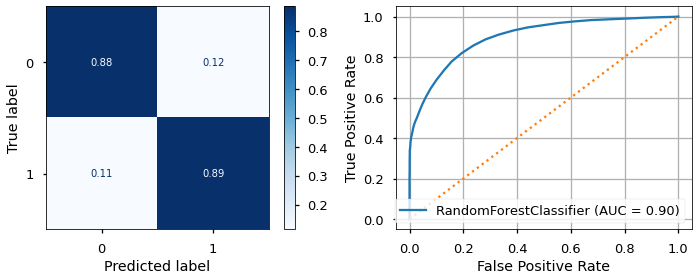


|---------------------------- Classification Report - Training Data ------------------------|

              precision    recall  f1-score   support

           0       0.99      0.94      0.97     56374
           1       0.91      0.99      0.95     33168

    accuracy                           0.96     89542
   macro avg       0.95      0.96      0.96     89542
weighted avg       0.96      0.96      0.96     89542



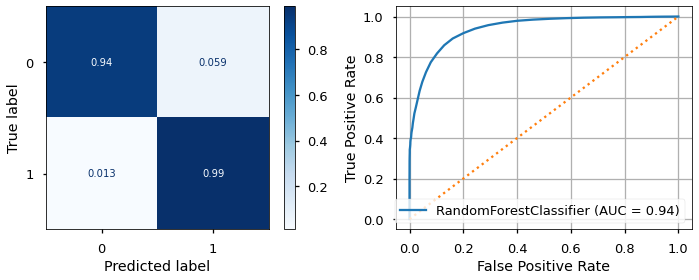

In [32]:
clf.evaluate_classification(rfc, X_train = X_train_tf_df, y_train = y_train,
                           X_test = X_test_tf_df, y_test = y_test,
                          metric = 'balanced recall')

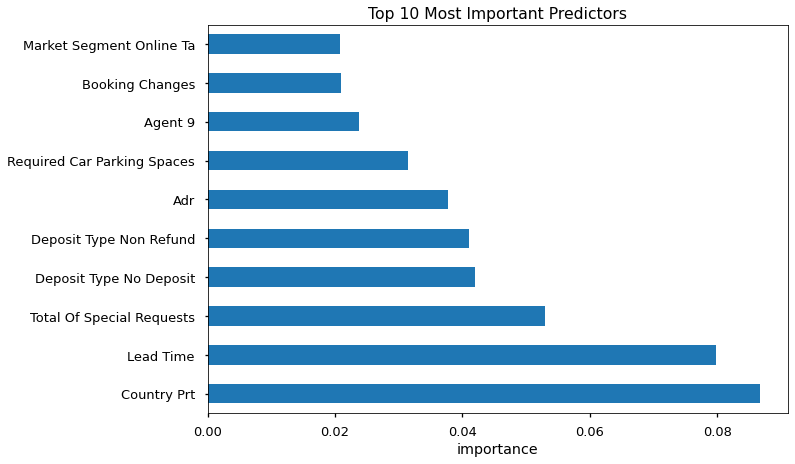

In [52]:
clf.plot_importances(rfc, X_train_tf_df)

# **AdaBoost Model**

---

**Results:**

> Training balanced recall score: 0.82
>
> Testing balanced recall score: 0.81
>
> * *The training score is larger by 0.01 points.*
>
> Training data log loss: 0.68
>
> Testing data log loss: 0.68

---

**Interpretation**

> 

---

In [34]:
# abc = AdaBoostClassifier(n_estimators=100, random_state=42)

# abc.fit(X_train_tf_df, y_train)

In [35]:
# clf.evaluate_classification(abc, X_train = X_train_tf_df, y_train = y_train,
#                            X_test = X_test_tf_df, y_test = y_test,
#                           metric = 'balanced recall')

# **Gradient Boosting Model**

---

**Results:**

> Training score: 0.81
> 
> Testing score: 0.80
> 
> * *The scores are the same size.*
>
> Training data log loss: 0.4
>
> Testing data log loss: 0.4

---

**Interpretation**

> 

---

In [36]:
# gbc = GradientBoostingClassifier(n_iter_no_change  = 5, random_state=42)

# gbc.fit(X_train_tf_df, y_train)

In [37]:
# clf.evaluate_classification(gbc, X_train = X_train_tf_df, y_train = y_train,
#                            X_test = X_test_tf_df, y_test = y_test,
#                           metric = 'balanced recall')

# **ExtraTreesClassifier**

---

**Results:**

> Training balanced recall score: 1.0
> 
> Testing balanced recall score: 0.87
> 
> * 
>
> Training data log loss: 0.01
>
> Testing data log loss: 0.33

---

**Interpretation**

> 

---

In [38]:
# etc = ExtraTreesClassifier(class_weight = 'balanced', n_jobs=-1, random_state=42)

# etc.fit(X_train_tf_df, y_train)

In [39]:
# clf.evaluate_classification(etc, X_train = X_train_tf_df, y_train = y_train,
#                            X_test = X_test_tf_df, y_test = y_test,
#                           metric = 'balanced recall')

# **XGBoost Classifier**

---

**Results:**

> Training balanced accuracy score: 0.86
> 
> Testing balanced accuracy score: 0.86
> 
> * *The scores are the same size.*
>
> Training data log loss: 0.24
>
> Testing data log loss: 0.26

---

**Interpretation**

> 

---

In [40]:
# xbgc = XGBClassifier(n_jobs = 4, random_state=42)
# xbgc.fit(X = X_train_tf_df, y=y_train)

In [41]:
# clf.evaluate_classification(xbgc,X_train_tf_df, y_train, X_test_tf_df, y_test,
#                             metric= 'balanced accuracy')

# **GridSearchCV Results**

# -- > 🛑 **FIX**: Rerun w/ KFCV, new data

## **GridSearchCV - Logistic Regression**

---

**Results:**

> *Results unavailable - did not run model due to time required*

---

**Interpretation**

> 

---

In [42]:
# lr_params = {
#  'C': [.001, .01, .1, 1],
#     'penalty':['l1', 'l2'],#, 'elasticnet', 'none'],
#     'solver':['newton-cg', 'liblinear', 'sag', 'saga', 'lbfgs'],
#     'max_iter':[100, 300, 500]}

# gscv = GridSearchCV(LogisticRegression(class_weight='balanced'), lr_params,
#                     scoring = 'balanced_accuracy', cv=3, n_jobs = -1)
# gscv

# gscv.fit(X_train_tf_df, y_train)

In [43]:
# clf.evaluate_classification(gscv.best_estimator_, X_train = X_train_tf_df, y_train = y_train,
#                            X_test = X_test_tf_df, y_test = y_test,
#                           metric = 'balanced accuracy')

In [44]:
# logreg_params = gscv.best_params_

# logreg_params

In [45]:
# gscv.best_estimator_

## **GSCV - RandomForest**

---

**Scores**

> Training balanced accuracy score: 0.99
> 
> Testing balanced accuracy score: 0.88
> 
> * *The training score is larger by 0.11 points.*
>
> Training data log loss: 0.10
>
> Testing data log loss: 0.26

---

**Best Parameters**

> 'criterion': 'entropy'
> 
> 'max_depth': None
> 
> 'min_samples_leaf': 2
> 
> 'min_samples_split': 2

**Interpretation**

> 

---

In [46]:
# rfc_params = {
#     'criterion': ['gini', 'entropy'],
#     'max_depth': [25,50, None],
#     'min_samples_split': [2,3,4],
#     'min_samples_leaf': [1,2]
# }

In [47]:
# rfgs = GridSearchCV(RandomForestClassifier(class_weight = 'balanced',
#                                            random_state = 42, n_jobs=-1),
#                     rfc_params,scoring = 'balanced_accuracy',
#                     cv=3,verbose = 4)

# rfgs.fit(X_train_tf_df, y_train)

In [48]:
# rfgs.best_params_

In [49]:
# rfgs.best_score_

In [50]:
# rfc_new = rfgs.best_estimator_

In [51]:
# clf.evaluate_classification(rfc_new, X_train_tf_df, y_train, X_test_tf_df, 
#                            y_test, 'balanced recall')

# Balanced Bagging Classifier

---

**MODEL: BalancedBaggingClassifier**

**Scores**

> Training balanced accuracy score: 0.98
> 
> Testing balanced accuracy score: 0.89
> 
> * *The training score is larger by 0.11 points.*
>
> Training data log loss: 0.11
>
> Testing data log loss: 0.30

---

**Interpretation**

> 

---

In [ ]:
## Testing balanced bagging classifier
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier

balanced_bagging = BalancedBaggingClassifier\
                (base_estimator=GradientBoostingClassifier(random_state=42),
                 n_estimators=10, n_jobs=4, random_state=42)

balanced_bagging.fit(X_train_tf_df, y_train)

In [ ]:
# clf.evaluate_classification(balanced_bagging, X_train = X_train_tf_df, y_train = y_train,
#                            X_test = X_test_tf_df, y_test = y_test,
#                           metric = 'balanced recall')

## GSCV: Balanced Bagging

---

**MODEL:** GridSearchCV - BalancedBaggingClassifier

**Scores**

> Training balanced accuracy score: 0.96
> 
> Testing balanced accuracy score: 0.89
> 
> * *The training score is larger by 0.07 points.*
>
> Training data log loss: 0.20
>
> Testing data log loss: 0.30

---

**Best Parameters**

> 'base_estimator': RandomForestClassifier()
>
> 'replacement': 'True'
>
> 'sampling_strategy': 'majority'

**Interpretation**

> 

---

In [ ]:
# bal_bag_params = {'base_estimator': [RandomForestClassifier()],
#                   'replacement': ['True'],
#                   'sampling_strategy': ['majority', 'not minority',
#                                         'not majority', 'all']
#                  }

In [ ]:
# bbgs = GridSearchCV(BalancedBaggingClassifier(n_jobs=-1,random_state=42), 
#                     bal_bag_params, scoring = 'balanced_accuracy',
#                     cv=3, verbose = 4)

# bbgs.fit(X_train_tf_df, y_train)

In [ ]:
# clf.evaluate_classification(bbgs, X_train_tf_df, y_train, X_test_tf_df, 
#                            y_test, 'balanced accuracy')

In [ ]:
# bbgs_params = bbgs.best_params_

# bbgs_params

# Balanced Random Forest Classifier

---

**MODEL: BalancedRandomForestClassifier**

**Scores**

> Training balanced accuracy score: 0.97
> 
> Testing balanced accuracy score: 0.89
> 
> * *The training score is larger by 0.8 points.*
>
> Training data log loss: 0.17
>
> Testing data log loss: 0.30

---

**Best Parameters**

> 

**Interpretation**

> 

---

In [ ]:
from imblearn.ensemble import BalancedRandomForestClassifier

balanced_forest = BalancedRandomForestClassifier(n_jobs = -1, random_state=42)

balanced_forest.fit(X_train_tf_df, y_train)

In [ ]:
clf.evaluate_classification(balanced_forest, X_train = X_train_tf_df, y_train = y_train,
                           X_test = X_test_tf_df, y_test = y_test,
                          metric = 'balanced recall')

### GSCV: Balanced Random Forest Classifier

---

**MODEL:** GridSearchCV - BalancedBaggingClassifier

**Scores**

> Training balanced accuracy score: 0.96
> 
> Testing balanced accuracy score: 0.89
> 
> * *The training score is larger by 0.07 points.*
>
> Training data log loss: 0.20
>
> Testing data log loss: 0.30

---

**Best Parameters**

> * 'criterion': 'entropy'
>
> * 'max_features': None
>
> * 'min_samples_leaf': 1
>
> * 'min_samples_split': 2

**Interpretation**

> 

---

In [ ]:
brfc_params = {'criterion': ['gini', 'entropy'],
               'min_samples_split': [2, 3, 4],
               'min_samples_leaf': [1,2,3]
              }

In [ ]:
brfc = GridSearchCV(BalancedRandomForestClassifier(n_jobs=-1,random_state=42), 
                    brfc_params,scoring = 'balanced_accuracy',
                    cv=3,verbose = 4)

brfc.fit(X_train_tf_df, y_train)

In [ ]:
clf.evaluate_classification(brfc, X_train_tf_df, y_train, X_test_tf_df, 
                           y_test, 'balanced precision')

In [ ]:
brfc_params = brfc.best_params_

brfc_params

In [ ]:
brfc.best_score_

In [ ]:
brfc_params = {'criterion': ['entropy'],
               'min_samples_split': [2],
               'min_samples_leaf': [1],
               'class_weight': ['balanced', 'balanced_subsample']
              }

In [ ]:
brfc = GridSearchCV(BalancedRandomForestClassifier(n_jobs=-1,random_state=42), 
                    brfc_params,scoring = 'balanced_accuracy',
                    cv=3,verbose = 4)

brfc.fit(X_train_tf_df, y_train)

In [ ]:
clf.evaluate_classification(brfc, X_train_tf_df, y_train, X_test_tf_df, 
                           y_test, 'balanced precision')

## EasyEnsembleClassifier

---

**MODEL: EasyEnsembleClassifier**

**Scores**

> Training balanced accuracy score: 0.86
> 
> Testing balanced accuracy score: 0.85
> 
> * *The training score is larger by 0.01 points.*
>
> Training data log loss: 0.64
>
> Testing data log loss: 0.64

---

**Interpretation**

> 

---

In [ ]:
# easy_ensemble = EasyEnsembleClassifier(n_jobs = -1, random_state=42)

# easy_ensemble.fit(X_train_tf_df, y_train)

In [ ]:
# clf.evaluate_classification(easy_ensemble, X_train = X_train_tf_df, y_train = y_train,
#                            X_test = X_test_tf_df, y_test = y_test,
#                           metric = 'balanced recall')

## RUSBoostClassifier

---

**MODEL: RUSBoostClassifier**

**Scores**

> Training balanced accuracy score: 0.85
> 
> Testing balanced accuracy score: 0.85
> 
> * *The scores are the same size.*
>
> Training data log loss: 0.64
>
> Testing data log loss: 0.64

---

**Interpretation**

> 

---

In [ ]:
# rus_boost = RUSBoostClassifier(n_estimators=200, algorithm='SAMME.R',
#                                random_state=42)

# rus_boost.fit(X_train_tf_df, y_train)

In [ ]:
# clf.evaluate_classification(rus_boost, X_train = X_train_tf_df, y_train = y_train,
#                            X_test = X_test_tf_df, y_test = y_test,
#                           metric = 'balanced recall')

# MVP Notes

* CLF results - feature importances
* feature importances - visualize via SHAP


# Model Results

---

> After testing several models, I found that MODELNAMEHERE produced the most accurate results.
>
> TOP 5 STRONGEST INDICATORS - Canceled Reservations:
> * 
> * 
> * 
>
> TOP 5 STRONGEST INDICATORS - Actualized Reservations:
> * 
> * 
> * 

---

# Recommendations

---

> Operationally, these results give us data-supported insights into our future guests and their needs. Once deployed, hotels would be able to use this model to forecast potential occupancy and staffing/supply needs. 
>
> Additionally, Operations teams would be able to determine how many and which guests would be the most likely to cancel their reservations. This information is very useful during periods of high-occupancy, particularly when trying to determine which guests to relocate in case of an oversold hotel.

---

# Future Work

---

> Time series modeling - forecasting based off of daily average probabilities (for a given # of arrivals, what is the forecast of %/# CXL?

> TSM - vector autoregressive forecasting using features to predict # cxl

> *Major stretch goal/future work:* determining likelihood of cancellations at given thresholds - e.g. 0-3, 4-7, 7-14, etc. days out
* What would be feature importances/coefficients at each threshold?
* Could I group the reservations based on their lead time despite different years?

---